In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

from sarix import sarix
import numpy as np
import pandas as pd
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import covidcast
from datetime import date

In [3]:
def load_data(as_of = None, end_day = "2021-07-01"):
    """
    Load data for MA Change healthcare CLI, cases, and hosps from covidcast
    
    Parameters
    ----------
    as_of: string of date in YYYY-MM-DD format.
        Default to None.
    end_day: string of date in YYYY-MM-DD format.
        Default to "2021-07-01"
    
    Returns
    -------
    df: data frame
        It has columns location, date, inc_hosp, population and rate.
        It is sorted by location and date columns in ascending order.
    """
    # load hospitalizations
    hosp_df = covidcast.signal(data_source="hhs",
                               signal="confirmed_admissions_covid_1d",
                               start_day=date.fromisoformat("2020-10-01"),
                               end_day=date.fromisoformat(end_day),
                               geo_type="state",
                               geo_values="ma",
                               as_of=as_of)
    hosp_df = hosp_df[["geo_value", "time_value", "value"]]
    hosp_df.columns = ["location", "date", "hosp"]
    
    # load cases
    case_df = covidcast.signal(data_source="jhu-csse",
                          signal="confirmed_incidence_num",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values="ma",
                          as_of=None)
    case_df = case_df[["geo_value", "time_value", "value"]]
    case_df.columns = ["location", "date", "case"]
    
    # load cases
    change_cli_df = covidcast.signal(data_source="chng",
                          signal="smoothed_outpatient_cli",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values="ma",
                          as_of=None)
    change_cli_df = change_cli_df[["geo_value", "time_value", "value"]]
    change_cli_df.columns = ["location", "date", "change_cli"]
    
    # merge
    df = case_df.merge(hosp_df, on=["location", "date"], how = "left") \
        .merge(change_cli_df, on=["location", "date"], how = "left")

    return df

df = load_data(end_day="2021-06-01")
df

,location,date,case,hosp,change_cli
0,ma,2020-10-01,754.0,42.0,2.975543
1,ma,2020-10-02,761.0,43.0,3.000890
2,ma,2020-10-03,672.0,33.0,3.945370
3,ma,2020-10-04,644.0,44.0,5.152087
4,ma,2020-10-05,515.0,40.0,5.024046
...,...,...,...,...,...
239,ma,2021-05-28,287.0,33.0,0.825896
240,ma,2021-05-29,224.0,17.0,0.732608
241,ma,2021-05-30,162.0,26.0,0.853270
242,ma,2021-05-31,0.0,21.0,1.120969


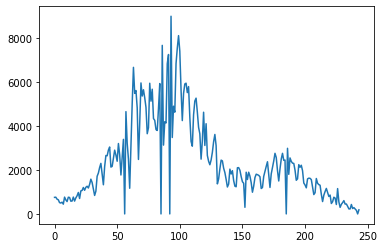

In [6]:
plt.plot(df.case)

/home/eray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


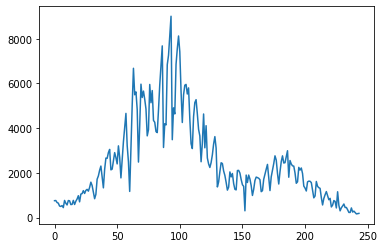

In [7]:
# quick fix to zero values; mean of adjacent
df['case_fixed'] = df.case
zero_inds = np.where(df.case == 0)
df['case_fixed'].iloc[zero_inds] = 0.5 * (df['case_fixed'].iloc[zero_inds[0] - 1].values + df['case_fixed'].iloc[zero_inds[0] + 1].values)
plt.plot(df.case_fixed)

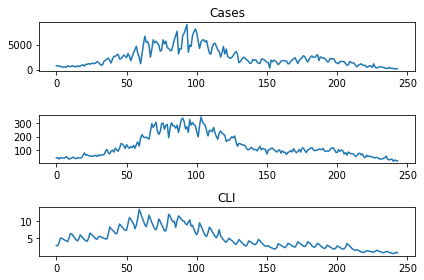

In [13]:
fig, ax = plt.subplots(3, 1, )
ax[0].plot(df.case_fixed)
ax[0].title.set_text('Cases')

ax[1].plot(df.hosp)
ax[2].title.set_text('Hosp')

ax[2].plot(df.change_cli)
ax[2].title.set_text('CLI')

plt.tight_layout()

In [47]:
# helper function to plot forecasts
def plot_forecasts(model_fit, var_names):
    t = onp.arange(model_fit.xy.shape[0])
    t_pred = model_fit.xy.shape[0] - 50 + onp.arange(model_fit.forecast_horizon)

    percentile_levels = [2.5, 97.5]
    median_prediction = onp.median(model_fit.samples['xy_future'], axis=0)
    percentiles = onp.percentile(model_fit.samples['xy_future'], percentile_levels, axis=0)
    median_prediction_orig = onp.median(model_fit.predictions_orig, axis=0)
    percentiles_orig = onp.percentile(model_fit.predictions_orig, percentile_levels, axis=0)

    fig, ax = plt.subplots(2 * len(var_names), 1, figsize=(10,3 * 2 * len(var_names)))

    for (i, var_name) in enumerate(var_names):
        ax[0 + i*2].fill_between(t_pred, percentiles_orig[0, :, i], percentiles_orig[1, :, i], color='lightblue')
        ax[0 + i*2].plot(t_pred, median_prediction_orig[:, i], 'blue', ls='solid', lw=2.0)
        ax[0 + i*2].plot(t, model_fit.xy_orig[:, i], 'black', ls='solid')
        ax[0 + i*2].set(xlabel="t", ylabel=var_name, title="Mean predictions with 95% CI")

        ax[1 + i*2].fill_between(t_pred, percentiles[0, :, i], percentiles[1, :, i], color='lightblue')
        ax[1 + i*2].plot(t_pred, median_prediction[:, i], 'blue', ls='solid', lw=2.0)
        ax[1 + i*2].plot(t, model_fit.xy[:, i], 'black', ls='solid')
        ax[1 + i*2].set(xlabel="t", ylabel=var_name + " (" + model_fit.transform + " scale)", title="Mean predictions with 95% CI")


    plt.tight_layout()

    plt.show()


In [37]:
# quick reload for debug
from importlib import reload
sarix = reload(sarix)

In [38]:
sarix_fit_hosp_only = sarix.SARIX(
    xy = df[["hosp"]].values[:-50],
    p = 2,
    P = 1,
    season_period = 7,
    transform = "fourth_rt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)


sample: 100%|██████████| 2000/2000 [00:08<00:00, 234.37it/s, 511 steps of size 1.29e-02. acc. prob=0.95] 



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
betas_update_var[0]      0.12      0.01      0.12      0.11      0.12    595.85      1.00
           theta[0]      0.65      0.07      0.65      0.52      0.75    489.45      1.00
           theta[1]      0.21      0.07      0.21      0.10      0.33    405.13      1.00
           theta[2]      0.45      0.07      0.45      0.34      0.55    672.85      1.00
           theta[3]     -0.06      0.09     -0.06     -0.21      0.07    590.27      1.00
           theta[4]     -0.24      0.07     -0.24     -0.35     -0.14    667.24      1.00
        theta_sd[0]      0.48      0.18      0.44      0.24      0.74    649.54      1.00
     xy_future[0,0]      3.14      0.11      3.14      2.95      3.32    673.58      1.00
     xy_future[1,0]      3.16      0.13      3.15      2.94      3.38    374.63      1.00
     xy_future[2,0]      3.15      0.16      3.15      2.91      3.41    289.07      1.00
     xy_f

<ipython-input-47-58b379ae7186>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


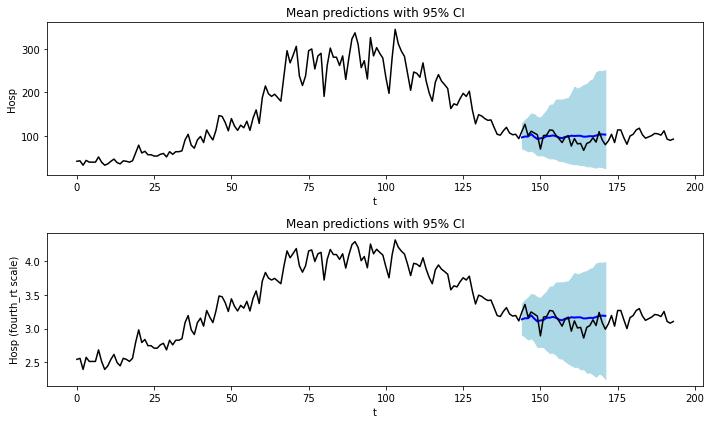

In [48]:
plot_forecasts(sarix_fit_hosp_only, ['Hosp'])

In [26]:
sarix_fit_cases = sarix.SARIX(
    xy = df[["case_fixed", "hosp"]].values[:-50],
    p = 2,
    P = 1,
    season_period = 7,
    transform = "fourth_rt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:24<00:00, 80.03it/s, 511 steps of size 1.11e-02. acc. prob=0.94]  



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
betas_update_var[0]      0.42      0.02      0.42      0.38      0.45   1207.78      1.00
betas_update_var[1]      0.11      0.01      0.11      0.10      0.12    770.74      1.00
           theta[0]      0.47      0.07      0.47      0.36      0.59    889.24      1.00
           theta[1]      0.23      0.07      0.23      0.13      0.35    613.41      1.00
           theta[2]      0.59      0.06      0.59      0.49      0.69    880.75      1.00
           theta[3]     -0.03      0.08     -0.03     -0.17      0.10    838.56      1.00
           theta[4]     -0.26      0.07     -0.26     -0.37     -0.14    784.40      1.00
           theta[5]      0.00      0.02      0.00     -0.03      0.04    714.05      1.00
           theta[6]      0.06      0.02      0.06      0.03      0.09   1075.21      1.00
           theta[7]     -0.01      0.02     -0.01     -0.04      0.02   1139.65      1.00
         

<ipython-input-47-58b379ae7186>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


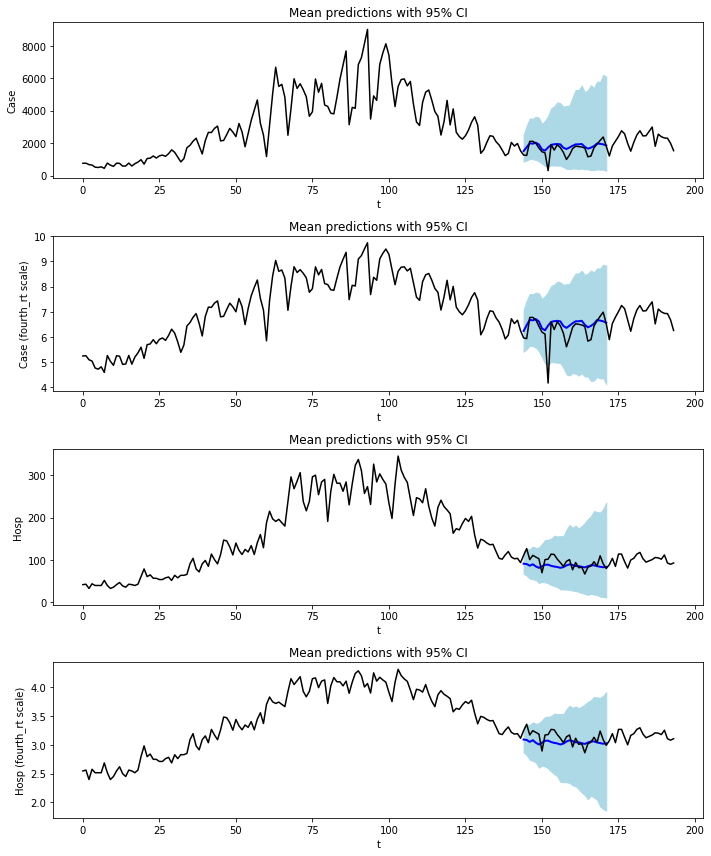

In [49]:
plot_forecasts(sarix_fit_cases, ['Case', 'Hosp'])

In [50]:
sarix_fit_cli_cases = sarix.SARIX(
    xy = df[["change_cli", "case_fixed", "hosp"]].values[:-50],
    p = 2,
    P = 1,
    season_period = 7,
    transform = "fourth_rt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:53<00:00, 37.59it/s, 511 steps of size 5.89e-03. acc. prob=0.94] 



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
betas_update_var[0]      0.03      0.00      0.03      0.02      0.03   1285.14      1.00
betas_update_var[1]      0.42      0.02      0.42      0.38      0.46   1192.11      1.00
betas_update_var[2]      0.11      0.01      0.11      0.10      0.12    982.94      1.00
           theta[0]      1.01      0.07      1.01      0.89      1.13    580.63      1.00
           theta[1]     -0.11      0.07     -0.11     -0.25     -0.00    580.07      1.00
           theta[2]      0.81      0.04      0.81      0.76      0.89   1177.06      1.00
           theta[3]     -0.73      0.09     -0.73     -0.87     -0.59    640.56      1.00
           theta[4]      0.02      0.07      0.02     -0.10      0.13    632.10      1.00
           theta[5]      0.47      0.07      0.48      0.36      0.60    911.47      1.00
           theta[6]      0.23      0.08      0.23      0.11      0.36    817.47      1.00
         

<ipython-input-47-58b379ae7186>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


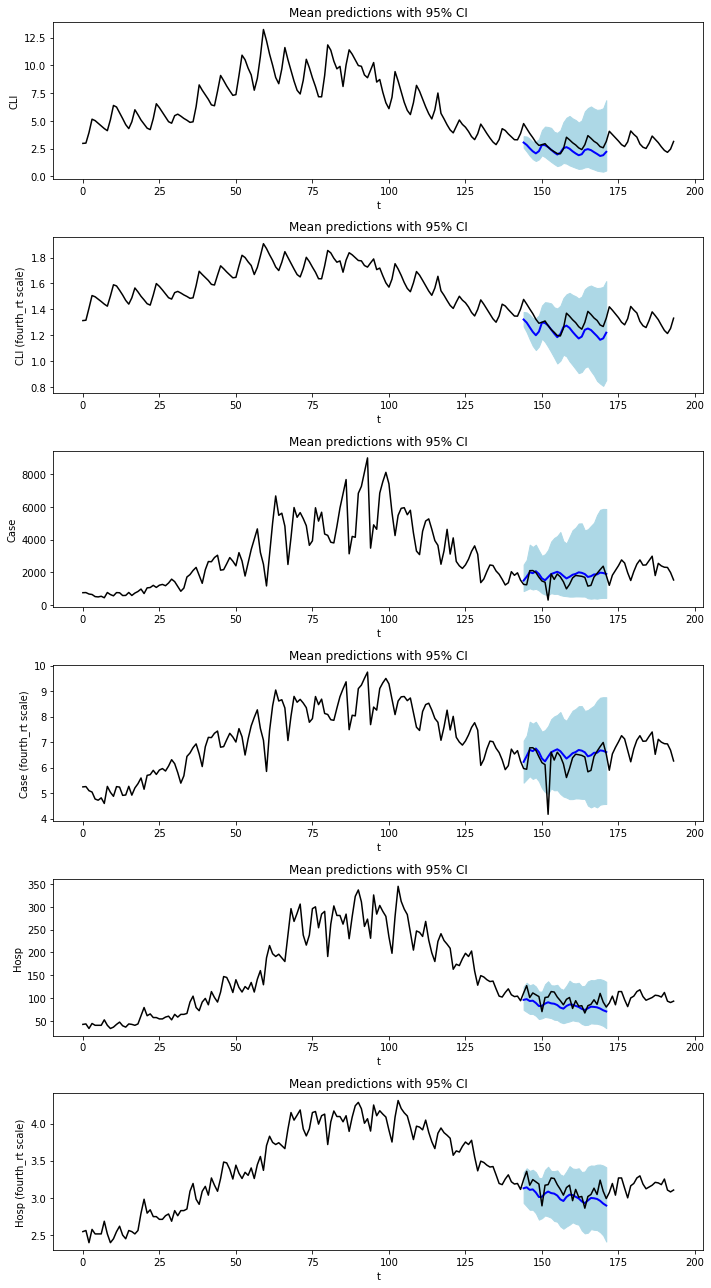

In [51]:
plot_forecasts(sarix_fit_cli_cases, ['CLI', 'Case', 'Hosp'])